## 분석하면서 생각한 핵심포인트
  - train[family_size] > 7 인 이상치 제거
  - 중복 데이터 처리를 위해 개인정보를 모두 합쳐 ID 변수 생성
  (단, 같은 사용자가 여러번 카드를 발급할 수 있다는 가정 하에 begin_month는 개인정보에서 제외함)
  - 개인의 특성이 될 만한 파생변수 추가 
  - Catboost 모델 사용

### Google Colab mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 패키지 설치

In [ ]:
!pip install catboost

## 라이브러리 구성

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool


## 데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/data_folder/카드 데이터/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

## 데이터 전처리

### 1. 결측치 처리

In [ ]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

### 2. 이상치 처리
-  train['family_size'] > 7 인 데이터 제거

In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

## Feature Engineering

### 1. 의미없는 변수 제거
- index 제거
- FLAG_MOBIL 삭제:모든 값이 1로 동일 

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### 2. DAYS_EMPLOYED 
- 양수인 데이터는 현재 무직자로 판단, 0 처리

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
-  음수값 -> 양수 변환

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### 4. 파생변수
 - numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
 - category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을때 가장 logloss가 낮았음

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    df['ability2'] = df['income_total'] / df['Age']
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)


    df['ID5'] = \
    df['before_EMPLOYED'].astype(str) + '_'+ df['ability'].astype(str)


### 파생변수와 다중공선을 보이는 컬럼 삭제

In [ ]:
cols = ['phone','gender','work_phone','car','child_num','email','reality','before_EMPLOYED','income_total_befofeEMP_ratio',
        'before_EMPLOYED_m','before_EMPLOYED_w','Age','DAYS_BIRTH_m','DAYS_BIRTH_w','EMPLOYED','DAYS_EMPLOYED_m','DAYS_EMPLOYED_w','ability','income_mean',
        'income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','family_size','ability2','ID']
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

### Numeric, Category 컬럼 분류

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  1
Number of Categorical features:  1


## Modeling - catboost


In [ ]:
n_est = 2000
seed = 42
n_fold = 12
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type','edu_type','family_type','house_type','occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=categorical_feats)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=categorical_feats)

  model_cat = CatBoostClassifier(n_est, depth = 3)
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=450, verbose=150)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.088314
0:	learn: 1.0485295	test: 1.0479322	best: 1.0479322 (0)	total: 40.7ms	remaining: 1m 21s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

150:	learn: 0.7159042	test: 0.6592396	best: 0.6592396 (150)	total: 2.83s	remaining: 34.7s
300:	learn: 0.7119217	test: 0.6574770	best: 0.6574446 (299)	total: 8.34s	remaining: 47.1s
450:	learn: 0.7091777	test: 0.6564612	best: 0.6564612 (450)	total: 14.8s	remaining: 50.8s
600:	learn: 0.7070039	test: 0.6558359	best: 0.6556890 (562)	total: 22s	remaining: 51.3s
750:	learn: 0.7052876	test: 0.6556248	best: 0.6553936 (728)	total: 27.1s	remaining: 45s
900:	learn: 0.7037601	test: 0.6561322	best: 0.6553828 (788)	total: 29.6s	remaining: 36.1s
1050:	learn: 0.7022842	test: 0.6561558	best: 0.6553828 (788)	total: 32.2s	remaining: 29s
1200:	learn: 0.7009965	test: 0.6562864	best: 0.6553828 (788)	total: 34.8s	remaining: 23.1s
Stopped by overfitting detector  (450 iterations wait)

bestTest = 0.6553828436
bestIteration = 788

Shrink model to first 789 iterations.
CV Log Loss Score: 0.655383

----------------- Fold 1 -----------------

Learning rate set to 0.088314
0:	learn: 1.0481540	test: 1.0489432	best: 

## Feautre Importance
 - ID의 중요도가 상당히 높게 나오는 것을 볼 수 있었음
 - plot_feature_importance 함수
    - ref) https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

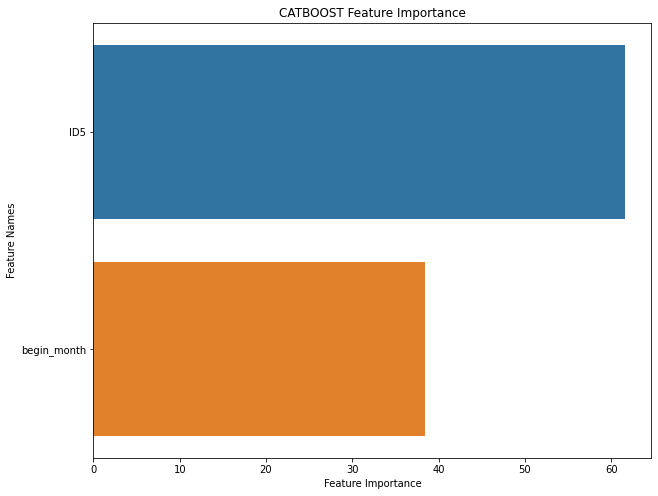

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## Submission

### submission 파일 불러오기

In [ ]:
sub = pd.read_csv(path + 'sample_submission.csv')

### submission 파일 저장

In [ ]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.095183,0.158146,0.746671
1,26458,0.301173,0.300578,0.398249
2,26459,0.040116,0.066411,0.893473
3,26460,0.049354,0.077596,0.873050
4,26461,0.061895,0.246676,0.691429
...,...,...,...,...
9995,36452,0.063520,0.240279,0.696200
9996,36453,0.330683,0.168013,0.501304
9997,36454,0.039738,0.133869,0.826394
9998,36455,0.130988,0.331404,0.537609


In [ ]:
sub.to_csv('submission0523_Final.csv', index=False)